<img src="https://www.rp.edu.sg/images/default-source/default-album/rp-logo.png" width="200" alt="Republic Polytechnic"/>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/koayst-rplesson/SST_DP2025/blob/main/L13/L13_Answer.ipynb)

# Setup and Installation

You can run this Jupyter notebook either on your local machine or run it at Google Colab (preferred).

* For local machine, it is recommended to install Anaconda and create a new development environment called `SST_DP2025`.
* Pip/Conda install the libraries stated below when necessary.
---

# <font color='red'>ATTENTION</font>

## Google Colab
- If you are running this code in Google Colab, **DO NOT** store the API Key in a text file and load the key later from Google Drive. This is insecure and will expose the key.
- **DO NOT** hard code the API Key directly in the Python code, even though it might seem convenient for quick development.
- You need to enter the API key at Python code `getpass.getpass()` when ask.

## Local Environment/Laptop
- If you are running this code locally in your laptop, you can create a env.txt and store the API key there.
- Make sure env.txt is in the same directory of this Jupyter notebook.
- You need to install `python-dotenv` and run the Python code to load in the API key.

---
```
%pip install python-dotenv

from dotenv import load_dotenv

load_dotenv('env.tx')
openai_api_key = os.getenv('OPENAI_API_KEY')
```
---

## GitHub/GitLab
- **DO NOT** `commit` or `push` API Key to services like GitHub or GitLab.

## Tip
The message output from LangChain/LangGraph can be difficult to read. Use [Python Formatter](https://codebeautify.org/python-formatter-beautifier) to format the output for easy reading.

# Lesson 13

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain
%pip install --quiet -U langgraph
%pip install --quiet -U langchain-openai
%pip install --quiet -U langchain-community
%pip isntall --quiet -U tavily-python
%pip install --quiet -U wikipedia

In [ ]:
# langchain              0.3.11
# langgraph              0.2.59
# langchain-core         0.3.24
# langchain-openai       0.2.12
# langchain-community    0.3.12
# openai                 1.57.2
# pydantic               2.10.3
# tavily-python          0.5.0
# wikipedia              1.4.0

In [1]:
import getpass
import os

In [2]:
# setup the OpenAI API Key

# get OpenAI API key ready and enter it when ask
os.environ["OPENAI_API_KEY"] = getpass.getpass()

 ········


In [3]:
# Goto https://tavily.com/ and sign up to get an API key

# get Tavily Search API key ready and enter it when ask
os.environ["TAVILY_API_KEY"] = getpass.getpass()

 ········


## Memory

LangGraph has checkpoint that is a specific memory implementation which saves the state of the graph at various points of execution. The state in a graph is dynamically changed when executed. 

Persistent memory and checkpoints provides a way to store and retrieval historical states, allowing more complex workflows and human-in-the loop interactions

In [4]:
from langgraph.graph import MessagesState

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

from IPython.display import Image, display

import random

In [5]:
# define the nodes function

def multiply(a : int, b: int) -> int:
    """
    Multiply a and b
    Args:
       a: first int
       b: second int
    """
    return a * b

def add (a: int, b: int) -> int:
    """
    Add a and b
    Args:
       a: first int
       b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """
    Divide a and b
    Args:
       a: first int
       b: second int
    """
    return a / b

In [6]:
model = ChatOpenAI(
    model = 'gpt-4o-mini'
)

arithmetic_tools = [add, multiply, divide]
model_with_tools = model.bind_tools(arithmetic_tools)

# system message
sys_msg = SystemMessage(
    content="You are a helful assistant tasked with performing arithmetic operations."
)

# helpful assistant node
def assistant(state: MessagesState):
    return {"messages" : [model_with_tools.invoke([sys_msg] + state['messages'])]}

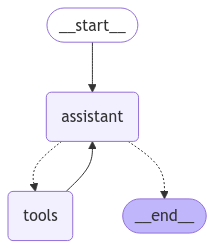

In [7]:
# build graph

graph_builder = StateGraph(MessagesState)

graph_builder.add_node('assistant', assistant)
graph_builder.add_node('tools', ToolNode(arithmetic_tools))

graph_builder.add_edge(START, 'assistant')
graph_builder.add_conditional_edges(
    'assistant',
    tools_condition
)

graph_builder.add_edge('tools', 'assistant')
without_memory_graph = graph_builder.compile()

display(Image(without_memory_graph.get_graph(xray=True).draw_mermaid_png()))

### Without Memory

In [8]:
test_msg = [HumanMessage(content='Add 10 and 10.')]
test_msg = without_memory_graph.invoke({'messages' : test_msg})

for m in test_msg['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 10.
================================== Ai Message ==================================
Tool Calls:
  add (call_q4wyyl1TGjXxgm39xbNzaMgp)
 Call ID: call_q4wyyl1TGjXxgm39xbNzaMgp
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: add

20
================================== Ai Message ==================================

The sum of 10 and 10 is 20.


In [9]:
# now let's multiply by 2

test_msg = [HumanMessage(content='Multiply by 10.')]
test_msg = without_memory_graph.invoke({'messages' : test_msg})

for m in test_msg['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply by 10.
================================== Ai Message ==================================

Could you please provide the number that you would like to multiply by 10?


### Observation

Observe that it cannot perform the multiuplication.  The output of `20` is not remembered.  This is because the state is transient to a single graph execution.

To solve this issue, we can use `persistence`. Use a `checkpointer` to automatically save the graph state after each step.

One of the checkpointers is `MemorySaver`. Simply compile the graph with a checkpointer and our graph has memory! When we use memory, we also need to specify a `thread_id`.

### With Memory

In [10]:
from langgraph.checkpoint.memory import MemorySaver

In [11]:
memory = MemorySaver()

thread = {"configurable": {"thread_id" : str(random.randint(1, 100))}}

with_memory_graph = graph_builder.compile(checkpointer=memory)

In [12]:
test_msg = [HumanMessage(content='Add 10 and 10.')]
test_msg = with_memory_graph.invoke({'messages' : test_msg}, thread)

for m in test_msg['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 10.
================================== Ai Message ==================================
Tool Calls:
  add (call_w69GYbHMRmfUCTxDIUeQ2ZrH)
 Call ID: call_w69GYbHMRmfUCTxDIUeQ2ZrH
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: add

20
================================== Ai Message ==================================

The sum of 10 and 10 is 20.


In [13]:
# now let's multiply by 2

test_msg = [HumanMessage(content='Multiply by 10.')]
test_msg = with_memory_graph.invoke({'messages' : test_msg}, thread)

for m in test_msg['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 10.
================================== Ai Message ==================================
Tool Calls:
  add (call_w69GYbHMRmfUCTxDIUeQ2ZrH)
 Call ID: call_w69GYbHMRmfUCTxDIUeQ2ZrH
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: add

20
================================== Ai Message ==================================

The sum of 10 and 10 is 20.
================================ Human Message =================================

Multiply by 10.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Uznx2igfbNiezeBmCHFlzW0W)
 Call ID: call_Uznx2igfbNiezeBmCHFlzW0W
  Args:
    a: 20
    b: 10
================================= Tool Message =================================
Name: multiply

200
================================== Ai Message ==================================

The result of 

### Observation

Observe the calculation is done from the initial one (addition) plus the latest step (multiply).

---

## Parallelization

Parallel node execution involves executing multiple nodes or tasks simultaneously rather than sequentially. This will be useful when tasks are independent of each other and can be processed in parallel to improve efficiency.

For example, you are building a system to analyze a user query across multiple knowledge sources simultaneously, such as Wikipedia, news articles, and a proprietary database. Each knowledge source requires its own processing logic. Such tasks are suitable for parallel node execution.

**Fan out** refers to a workflow pattern where a single input (or a small set of inputs) is distributed to multiple nodes or branches for parallel processing. Each node or branch works independently, often performing different tasks or processing the input in unique ways.

**Fan in** is the reverse of fan-out. It refers to a pattern where multiple independent outputs or results from parallel branches are merged or combined into a single unified output. This is often used after a fan-out pattern to aggregate, reduce, or process the results of parallel computations into a cohesive response.

In [14]:
from IPython.display import Image, display

import operator
import random

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import InvalidUpdateError

from typing import Annotated

In [15]:
class State(TypedDict):
    state: str

In [16]:
# Custom node

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

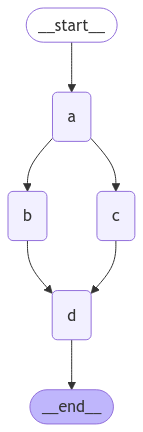

In [17]:
# Add nodes
memory = MemorySaver()

builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d") 
builder.add_edge("d", END)
without_operator_add_graph = builder.compile(checkpointer=memory)

display(Image(without_operator_add_graph.get_graph().draw_mermaid_png()))

In [18]:
thread = {"configurable": {"thread_id" : str(random.randint(1, 100))}}

try:
    test_msg = without_operator_add_graph.invoke({'state' : []}, thread)
except InvalidUpdateError as e:
    print(f'\nAn error has occurred: {e}')

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]

An error has occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


In [19]:
all_states = []
for state in without_operator_add_graph.get_state_history(thread):
    print(state)
    all_states.append(state)
    print('-'*10)

StateSnapshot(values={'state': ["I'm A"]}, next=('b', 'c'), config={'configurable': {'thread_id': '74', 'checkpoint_ns': '', 'checkpoint_id': '1efbec26-bac0-6248-8001-98d8a570c360'}}, metadata={'source': 'loop', 'writes': {'a': {'state': ["I'm A"]}}, 'thread_id': '74', 'step': 1, 'parents': {}}, created_at='2024-12-20T11:06:11.114247+00:00', parent_config={'configurable': {'thread_id': '74', 'checkpoint_ns': '', 'checkpoint_id': '1efbec26-baba-60ef-8000-19fbd66853c4'}}, tasks=(PregelTask(id='e5fe37c6-05e8-ac7c-6be8-32c51dbaf37b', name='b', path=('__pregel_pull', 'b'), error=None, interrupts=(), state=None, result={'state': ["I'm B"]}), PregelTask(id='2bb8ecc7-b61e-c442-955b-a68be282b049', name='c', path=('__pregel_pull', 'c'), error=None, interrupts=(), state=None, result={'state': ["I'm C"]})))
----------
StateSnapshot(values={'state': []}, next=('a',), config={'configurable': {'thread_id': '74', 'checkpoint_ns': '', 'checkpoint_id': '1efbec26-baba-60ef-8000-19fbd66853c4'}}, metadata=

### Observation
The error is caused by contention. Nodes 'b' and 'c' are trying to update at the same time.

When fanning out from node 'a', we need to ensure that we are using a `reducer` if the steps are writing to the same channel.  We need to apply `operator.add` to lists so that it performs a list concatenation.

In [20]:
class State(TypedDict):
    state: Annotated[list, operator.add]

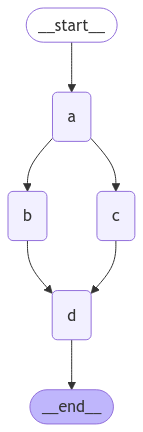

In [21]:
# repeat the same code as before

# Add nodes
memory = MemorySaver()

builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d") 
builder.add_edge("d", END)
with_operator_add_graph = builder.compile(checkpointer=memory)

display(Image(with_operator_add_graph.get_graph().draw_mermaid_png()))

In [22]:
thread = {"configurable": {"thread_id" : str(random.randint(1, 100))}}

try:
    test_msg = with_operator_add_graph.invoke({'state' : []}, thread)
except InvalidUpdateError as e:
    print(f'\nAn error has occurred: {e}')

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


### Observation
Noticed above the strings are concatenated.

---

### Filtering and Trimming Messages

**Filtering**
Removes irrelevant or redundant information from messages. This helps the LLM to focus on the most critical parts of the interaction.

**Trimming Messages**
Many LLMs have token limits (e.g., 4,096 or 8,000 tokens for certain OpenAI models). Exceeding this limit can result in incomplete processing or errors. Shortens the length of messages to fit within constraints, like token limits for LLMs.

In [23]:
from IPython.display import Image, display

from pprint import pprint

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, trim_messages

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

In [24]:
messages = [AIMessage("You said you want to learn quantum computing?", name="Bot", id="1")]
messages.append(HumanMessage("Yes. Please give me a quick summary to quantum computing.", name="John", id="2"))

In [25]:
model = ChatOpenAI(
    model = 'gpt-4o-mini'
)

In [26]:
# define a chat node
def chat_node(state:MessagesState):
    return {"messages" : model.invoke(state['messages'])}

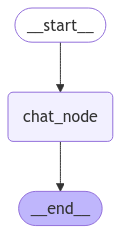

In [27]:
# build graph
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("chat_node", chat_node)
graph_builder.add_edge(START, "chat_node")
graph_builder.add_edge("chat_node", END)
graph = graph_builder.compile()

# view graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
# invoke graph

msg = graph.invoke({'messages' : messages})

for m in msg['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

You said you want to learn quantum computing?
================================ Human Message =================================
Name: John

Yes. Please give me a quick summary to quantum computing.
================================== Ai Message ==================================

Quantum computing is a type of computation that leverages the principles of quantum mechanics to process information. Unlike classical computers, which use bits as the smallest unit of data (represented as 0s and 1s), quantum computers use quantum bits, or qubits. 

Here are some key concepts:

1. **Qubits**: Qubits can exist in multiple states simultaneously due to a property called superposition. This allows quantum computers to process a vast amount of possibilities at once.

2. **Entanglement**: Qubits can become entangled, meaning the state of one qubit can depend on the state of another, no matter the distance betwe

In [29]:
msg

# take a look at how many 'input tokens', 'output_tokens' and 'total_tokens' in the output
# we will compare it after the trim_messages

{'messages': [AIMessage(content='You said you want to learn quantum computing?', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Yes. Please give me a quick summary to quantum computing.', additional_kwargs={}, response_metadata={}, name='John', id='2'),
  AIMessage(content="Quantum computing is a type of computation that leverages the principles of quantum mechanics to process information. Unlike classical computers, which use bits as the smallest unit of data (represented as 0s and 1s), quantum computers use quantum bits, or qubits. \n\nHere are some key concepts:\n\n1. **Qubits**: Qubits can exist in multiple states simultaneously due to a property called superposition. This allows quantum computers to process a vast amount of possibilities at once.\n\n2. **Entanglement**: Qubits can become entangled, meaning the state of one qubit can depend on the state of another, no matter the distance between them. This property enables complex correlati

In [30]:
# before trimming

msg['messages'][2].usage_metadata

{'input_tokens': 36,
 'output_tokens': 269,
 'total_tokens': 305,
 'input_token_details': {'audio': 0, 'cache_read': 0},
 'output_token_details': {'audio': 0, 'reasoning': 0}}

### Filtering

Don't pass in the last message in the queue (list) for the model (LLM) to process

In [31]:
# Don't want to process the last message. Call invoke without passing in the last message

filtered_msg = graph.invoke({'messages' : messages[:-1]})

for m in filtered_msg['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

You said you want to learn quantum computing?
================================== Ai Message ==================================

Yes, I can help you with that! Quantum computing is a fascinating and complex field. Do you have any specific questions or topics in mind that you would like to explore?


### Trimming

All models have finite context window. There is a limit on how many tokens the model can take as input. Long messages or a chain/ahent that accumulates a long history will cost more to process.

`trim_messages` can be used to reduce the size of a chat history to a specified token count or specified message count.

[API Reference: trim_messages](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.utils.trim_messages.html)

In [32]:
from langchain_core.messages import trim_messages

# trim_chat_node. Use trim_messages to trim
def trim_chat_node(state: MessagesState):
    trim_msg = trim_messages(
        state['messages'],
        max_tokens = 100,
        #start_on = 'human',
        #end_on = ("human", "tool"),
        strategy = "last",

        # use the same one as 'model' 
        token_counter = model,        
        allow_partial = False,
    )
    
    return {"messages": [model.invoke(trim_msg)]}

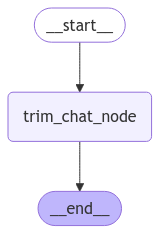

In [33]:
# build graph
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("trim_chat_node", trim_chat_node)
graph_builder.add_edge(START, "trim_chat_node")
graph_builder.add_edge("trim_chat_node", END)
graph = graph_builder.compile()

# view graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
# Before trimming
# observe the message history

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

You said you want to learn quantum computing?
================================ Human Message =================================
Name: John

Yes. Please give me a quick summary to quantum computing.


In [35]:
# trim the messages 
trimmed = graph.invoke({'messages': messages})

In [36]:
for m in trimmed['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

You said you want to learn quantum computing?
================================ Human Message =================================
Name: John

Yes. Please give me a quick summary to quantum computing.
================================== Ai Message ==================================

Quantum computing is a type of computation that utilizes the principles of quantum mechanics to process information. Unlike classical computers, which use bits as the smallest unit of data (represented as 0s and 1s), quantum computers use quantum bits or qubits. 

Key concepts include:

1. **Superposition**: Qubits can exist in multiple states simultaneously, allowing quantum computers to process a vast amount of information at once.

2. **Entanglement**: Qubits can become entangled, meaning the state of one qubit is directly related to the state of another, no matter the distance between them. This correlation enables mo

In [37]:
trimmed

# take a look at how many 'input tokens', 'output_tokens' and 'total_tokens' in the output below
# compare with the outputs from previous (before trimming)
# you should see some reduction in the token count (after trimming) ?

# is the trimmed output meet your expectation?

{'messages': [AIMessage(content='You said you want to learn quantum computing?', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Yes. Please give me a quick summary to quantum computing.', additional_kwargs={}, response_metadata={}, name='John', id='2'),
  AIMessage(content='Quantum computing is a type of computation that utilizes the principles of quantum mechanics to process information. Unlike classical computers, which use bits as the smallest unit of data (represented as 0s and 1s), quantum computers use quantum bits or qubits. \n\nKey concepts include:\n\n1. **Superposition**: Qubits can exist in multiple states simultaneously, allowing quantum computers to process a vast amount of information at once.\n\n2. **Entanglement**: Qubits can become entangled, meaning the state of one qubit is directly related to the state of another, no matter the distance between them. This correlation enables more complex computations.\n\n3. **Quantum Gates**

In [38]:
# After trimming
trimmed['messages'][2].usage_metadata

{'input_tokens': 36,
 'output_tokens': 216,
 'total_tokens': 252,
 'input_token_details': {'audio': 0, 'cache_read': 0},
 'output_token_details': {'audio': 0, 'reasoning': 0}}

---

## Reducer

### add_messages
`add_message(left: Messages, right: Messages, ...)`
It merges two list of messages, updating existing message by ID.
- The left side is the base list
- The right side is the list of messages to merge into the base list

[API Reference: add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#langgraph.graph.message.add_messages)

In [39]:
from langgraph.graph.message import add_messages

from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage

In [40]:
messages = [AIMessage(content = "Hello! How can I assist you?", name="Bot", id="1")]
messages.append(HumanMessage("I am looking for ultimate LangChain tutorial", name="John", id="2"))

In [41]:
messages

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='I am looking for ultimate LangChain tutorial', additional_kwargs={}, response_metadata={}, name='John', id='2')]

In [42]:
new_bot_message = AIMessage(content = "Any specific topics you desire?", name="Bot", id="3")

new_msg = add_messages(new_bot_message, messages)

In [43]:
new_msg

[AIMessage(content='Any specific topics you desire?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='I am looking for ultimate LangChain tutorial', additional_kwargs={}, response_metadata={}, name='John', id='2')]

### Re-writing

There is a userful trick when working with `add_messages` reducer.  If you pass a message with the same ID as an existing one in our message list, it will get over written

In [44]:
new_msg

[AIMessage(content='Any specific topics you desire?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='I am looking for ultimate LangChain tutorial', additional_kwargs={}, response_metadata={}, name='John', id='2')]

In [45]:
replacement_message = AIMessage(content = "What will you like to learn?", name="Bot", id="3")

In [46]:
replaced_msg = add_messages(new_msg, replacement_message)

In [47]:
replaced_msg

# observe that the message "Any specific topics you desire?" has been replaced with "What will you like to learn?"

[AIMessage(content='What will you like to learn?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='I am looking for ultimate LangChain tutorial', additional_kwargs={}, response_metadata={}, name='John', id='2')]

### Removal

To remove a message, we simply use `RemoveMessage`.

In [48]:
# assuming we just want to remove the last message

deleted_message = [RemoveMessage(id=m.id) for m in replaced_msg[:-2]]
delete_msg = add_messages(replaced_msg, deleted_message)

In [49]:
delete_msg

# observe the last message "What will you like to learn" is removed

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='I am looking for ultimate LangChain tutorial', additional_kwargs={}, response_metadata={}, name='John', id='2')]